## Imports

In [2]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
#export
from exp.nb_10 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mixup

In [6]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

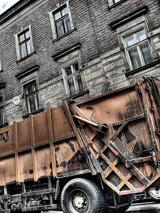

In [7]:
img1 = PIL.Image.open(ll.train.x.items[0])
img1

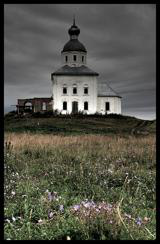

In [8]:
img2 = PIL.Image.open(ll.train.x.items[4000])
img2

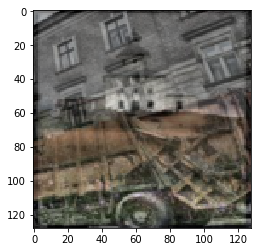

In [14]:
mixed_up = ll.train.x[0] * 0.5 + ll.train.x[4000] * 0.5
plt.imshow(mixed_up.permute(1,2,0));

In [17]:
t = lambda x: x.lgamma().exp()

In [18]:
facts = [math.factorial(i) for i in range(7)]

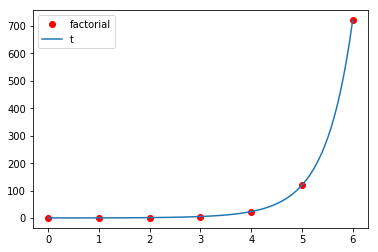

In [19]:
plt.plot(range(7), facts, 'ro')
plt.plot(torch.linspace(0,6), t(torch.linspace(0,6)+1))
plt.legend(['factorial','t']);

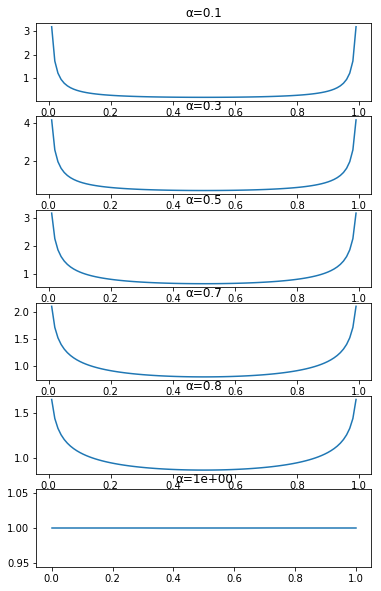

In [33]:
_,axs = plt.subplots(6,1, figsize=(6,10))
x = torch.linspace(0,1, 100)
for α,ax in zip([0.1, 0.3, 0.5, 0.7, 0.8, 1.], axs):
    α = tensor(α)
#     y = (x.pow(α-1) * (1-x).pow(α-1)) / (gamma_func(α ** 2) / gamma_func(α))
    y = (x**(α-1) * (1-x)**(α-1)) / (Γ(α)**2 / Γ(2*α))
    ax.plot(x,y)
    ax.set_title(f"α={α:.1}")

In [36]:
#export
class NoneReduce():
    def __init__(self, loss_func): 
        self.loss_func,self.old_red = loss_func,None
        
    def __enter__(self):
        if hasattr(self.loss_func, 'reduction'):
            self.old_red = getattr(self.loss_func, 'reduction')
            setattr(self.loss_func, 'reduction', 'none')
            return self.loss_func
        else: return partial(self.loss_func, reduction='none')
        
    def __exit__(self, type, value, traceback):
        if self.old_red is not None: setattr(self.loss_func, 'reduction', self.old_red)    

In [37]:
#export
from torch.distributions.beta import Beta

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss    

#export
class MixUp(Callback):
    _order = 90 #Runs after normalization and cuda
    def __init__(self, α:float=0.4): self.distrib = Beta(tensor([α]), tensor([α]))
    
    def begin_fit(self): self.old_loss_func,self.run.loss_func = self.run.loss_func,self.loss_func
    
    def begin_batch(self):
        if not self.in_train: return #Only mixup things during training
        λ = self.distrib.sample((self.yb.size(0),)).squeeze().to(self.xb.device)
        λ = torch.stack([λ, 1-λ], 1)
        self.λ = unsqueeze(λ.max(1)[0], (1,2,3))
        shuffle = torch.randperm(self.yb.size(0)).to(self.xb.device)
        xb1,self.yb1 = self.xb[shuffle],self.yb[shuffle]
        self.run.xb = lin_comb(self.xb, xb1, self.λ)
        
    def after_fit(self): self.run.loss_func = self.old_loss_func
    
    def loss_func(self, pred, yb):
        if not self.in_train: return self.old_loss_func(pred, yb)
        with NoneReduce(self.old_loss_func) as loss_func:
            loss1 = loss_func(pred, yb)
            loss2 = loss_func(pred, self.yb1)
        loss = lin_comb(loss1, loss2, self.λ)
        return reduce_loss(loss, getattr(self.old_loss_func, 'reduction', 'mean'))

In [39]:
nfs = [32,64,128,256,512]

def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=optim.SGD, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, 
#         ProgressCallback,
        partial(BatchTransformXCallback, norm_imagenette),
        MixUp]

learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

learn.fit(1)

['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy', 'time']
['0', '2.063482', '0.345665', '1.723823', '0.422000', '01:21']


In [40]:
learn.loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

## Mixup

In [42]:
#export
from exp.nb_10b import *

## Training Imagenette

## Text preprocessing

In [44]:
#export
from exp.nb_11a import *

In [45]:
path = datasets.untar_data(datasets.URLs.IMDB)

In [46]:
path.ls()

[PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/tmp_clas'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/train'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/tmp_lm'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/imdb.vocab'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/unsup'),
 PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/README')]

In [47]:
#export
def read_file(fn): 
    with open(fn, 'r', encoding = 'utf8') as f: return f.read()
    
class TextList(ItemList):
    @classmethod
    def from_files(cls, path, extensions='.txt', recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, i):
        if isinstance(i, Path): return read_file(i)
        return i

In [48]:
il = TextList.from_files(path, include=['train', 'test', 'unsup'])

In [49]:
len(il.items)

100000

In [50]:
txt = il[4]
txt

"This is seriously the worst movie I have ever seen, right from the start the movie goes straight down hill with its cheesy music score, poor acting, and total lack or real story or plot. Even for a B movie this is down right awful. After reading some of the good reviews i thought i'd keep an open mind and watch it. But all the bad reviews were so right. I totally can't understand how anyone could have enjoyed it. I'm a huge Sci-fi fan and this was way more than i could swallow. Definlty do yourself a favor a move on to a different movie. They are many other better movies that deal with this subject matter. YOU HAVE BEEN WARNED."

In [51]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.1))
sd

SplitData
Train: TextList (90067 items)
[PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/10137_2.txt'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/4526_1.txt'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/9267_4.txt'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/5281_1.txt'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/9451_1.txt'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/8661_1.txt'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/12075_3.txt'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/10504_1.txt'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/12460_2.txt'), PosixPath('/data/home/h216520/Desktop/fastai_work/data/imdb/test/neg/5527_4.txt')...]
Path: /data/home/h216520/Desktop/fastai_work/data/imdb
Valid: TextList (9933 items)
[PosixPath('/data/home/h216520/Desktop